# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Projects, and the OpenAI Agents SDK.

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

In [22]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Configure Azure OpenAI to work with OpenAI Agents SDK

In [23]:
import os
from agents import (
    set_default_openai_client,
    set_tracing_disabled,
    OpenAIChatCompletionsModel
)

# setup settings
from openai import AsyncAzureOpenAI
import nest_asyncio
nest_asyncio.apply()

# Use the synchronous client instead of the async one
openai_client = AsyncAzureOpenAI(
    azure_endpoint=os.getenv("AOAI_ENDPOINT"),
    api_key=os.getenv("AOAI_KEY"),
    api_version=os.environ.get("AOAI_API_VERSION", "2024-02-01")
)

# Configure SDK
set_default_openai_client(openai_client)
set_tracing_disabled(True)

reasoningModel = OpenAIChatCompletionsModel(
    model=os.getenv("reasoningModel"), 
    openai_client=openai_client
)

chatModel = OpenAIChatCompletionsModel(
    model=os.getenv("chatModel"),
    openai_client=openai_client
)

## Data Models for Research Workflow

The following Pydantic models define the structured data used throughout our research process:

1. **ResearchTask** - Represents an individual research task with specific search queries
2. **ResearchPlan** - Contains the overall plan with research objectives and tasks
3. **Citation** - Stores source information for proper attribution
4. **ComprehensiveResearchReport** - Defines the structure of the final research output
5. **PeerReviewFeedback** - Contains structured feedback on report quality

In [24]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchTask(BaseModel):
    id: Optional[str] = Field(None, description="Unique identifier for the task")
    subtopic: str = Field(..., description="Subtopic to research")
    search_queries: List[str] = Field(..., description="List of search queries to explore this subtopic")
    completed: bool = Field(..., description="Status of task completion")

class ResearchPlan(BaseModel):
    query: str = Field(..., description="The original user query that prompted this research")
    objective: str = Field(..., description="The overall research objective, clearly defined")
    success_criteria: List[str] = Field(..., description="Criteria to determine when the research is sufficiently complete.")
    related_topics: List[str] = Field(..., description="List of related topics that may be useful for the research.")
    research_tasks: List[ResearchTask] = Field(..., description="List of specific research tasks to complete. Each task focuses on a subtopic.")

class Citation(BaseModel):
    title: str
    url: str

class ComprehensiveResearchReport(BaseModel):
    objective: str = Field(..., description="The original research objective")
    research_report: str = Field(..., description=(
        "Comprehensive research report in markdown. "
        "It should be structured with meaningful headings and subsections, but emphasize **fully-developed paragraphs**. "
        "It should be long and detailed, and it should fully addresses the objectives, "
        "and the various subtopics required to achieve the success criteria. "
        "Use bullet points or lists **only** when they genuinely improve clarity (e.g., summarizing key data). "
        "Tables and other data visualizations are encouraged. "
        "The research report should always be long and detailed.\n\n" 
        "For citations, please use the IEEE (Institute of Electrical and Electronics Engineers). "
        "How it works:\n\n"
        "   1. In the text, use numbered citations in brackets [1].\n"
        "   2. At the end of the report, provide a list of citations in the format "
        "(the list should ONLY contain the sources used in the free text of the research report. "
        "Do NOT list sources which are not cited in the free text of the research report.):\n\n"
        "       [1] Title of the source, URL."
    ))
    citations: List[Citation] = Field(..., description=(
        "List of citations (title and URL), corresponding to references actually used in research_report. "
        "Do not add references that are not cited within the text."
    ))
    identified_gaps: Optional[List[str]] = Field(default=None, description="Identified information gaps.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Suggestions for additional research.")

class PeerReviewFeedback(BaseModel):
    overall_feedback: str = Field(..., description="General feedback on the report.")
    strengths: List[str] = Field(..., description="Aspects of the report that are well done.")
    suggested_improvements: List[str] = Field(..., description="Specific suggestions to improve clarity, completeness, accuracy, or structure.")
    additional_queries: Optional[List[str]] = Field(default=None, description="Additional research queries that could strengthen the report.")
    is_satisfactory: bool = Field(..., description="Indicates if the report meets all quality standards and no further revisions are needed.")
    

## Agent Configuration

The research workflow is powered by two types of agents:

1. **Azure AI Agents** - Created using Azure AI Projects for web search capabilities
2. **OpenAI Agents** - For specialized research tasks

Let's configure each type of agent with their specific instructions and capabilities.

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [25]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

The following cell will ***create*** an **Azure AI Agent**, so you only need to run this cell **once**.

In [26]:
# from azure.ai.agents.models import BingGroundingTool

# import datetime
# current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# bing_connection = project_client.connections.get(
#     name=os.getenv("BING_CONNECTION_NAME")
# )

# bing_tool = BingGroundingTool(connection_id=bing_connection.id)

# bing_search_agent = project_client.agents.create_agent(
#     name="bingSearchAgent",
#     description="Agent to perform web searches using Bing.",
#     model=os.getenv("chatModel"),
#     temperature=0.5,
#     tools=bing_tool.definitions,
#     instructions=f"""
# You are a helpful research assistant.

# Today's date is {current_date}.

# Use your available tools (like Bing web search) to find information relevant to the user's query.
# When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
# Provide a comprehensive answer based on the search results.
#     """.strip()
# )

If you already have an Azure AI Agent, run this cell to update it's instructions with today's date.

In [27]:
import datetime
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("bingSearchAgentID"))
bing_search_agent.instructions = f"""
You are a helpful research assistant.

Today's date is {current_date}.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.
""".strip()

print(bing_search_agent.instructions)

You are a helpful research assistant.

Today's date is 2025-06-05.

Use your available tools (like Bing web search) to find information relevant to the user's query.
When you use information from a search result in your answer, please cite the source clearly using the tool's citation capabilities.
Provide a comprehensive answer based on the search results.


**OpenAI Agents**

In [28]:
from agents import (
    Agent,
    ModelSettings
)

chatModelSettings=ModelSettings(
        max_tokens=32768,
        temperature=0.3,
    )

planner_agent = Agent(
    name="PlannerAgent",
    instructions=f"""
    Today's date is {current_date}.
    
    You are an expert research planner specializing in creating detailed research plans your task is to analyze a user's research query and create a structured research plan.
    with the following components:
    
    1. DOMAIN CLASSIFICATION:
       Classify the query into a fitting domain (e.g., technology, business, etc.).
       The Domain is not included in the output, but it is important for the other components in the research plan.
       The domain should be a single word (e.g., technology, business, etc.).
       
    2. RESEARCH OBJECTIVE:
       Create a clear, comprehensive objective statement for the research
       
    3. SUBTOPICS:
       Generate relevant subtopics that should be explored to thoroughly answer the query (Important. generate no less than 5 subtopics)
       
    4. SEARCH QUERIES:
       For each subtopic, provide search queries that will yield valuable results (Important. It's better to generate more queries than less queries, but at least 3 queries per subtopic)
       
    5. SUCCESS CRITERIA:
       List the criteria that will determine when the research is complete (Important. generate no less than 4 success criteria)
       Take all of the above into account (e.g., the domain, objective, subtopics, and search queries) to create the success criteria.
       
    6. RELATED TOPICS:
       suggest related topics that may be useful for the research (Important. generate no less than 3 related topics)
    
    Ensure each subtopic is thorough and directly relevant to the research query.
    The search queries should be specific enough to return high-quality results.
    """.strip(),
    model=chatModel,
    output_type=ResearchPlan,
    model_settings=chatModelSettings
)

summary_agent = Agent(
    name="SummaryAgent",
    instructions=(
        "You are a comprehensive research summarization specialist. Your task is to **synthesize information from combined search result content** related to a specific subtopic (which will be mentioned in the input prompt). "
        "Create a **single, coherent, detailed, and information-rich summary** that:\n\n"
        "1. Extracts ALL important facts, statistics, findings, and insights **relevant to the specified subtopic** from the combined text.\n"
        "2. Preserves specific numbers, percentages, dates, and technical details whenever present.\n"
        "3. Includes industry-specific terminology and concepts that add depth to the research.\n"
        "4. **Synthesizes** the key arguments and conclusions from the provided sources. If sources present different perspectives or data, try to capture that nuance.\n"
        "5. Provides thorough explanations rather than superficial overviews, integrating information smoothly.\n"
        "6. For technical content, preserves methodologies, technical specifications, and implementation details.\n"
        "7. For comparative content, maintains all sides of the comparison with their specific attributes.\n\n"

        "**Acknowledge that the input combines information potentially from multiple search results.** Your goal is to create a unified summary focused on the overall subtopic, not just list summaries of individual parts.\n\n"

        "Remember that your summary serves as the foundation for generating a comprehensive research report. The quality and depth of the final research report depends directly on how comprehensive and well-synthesized your summary is. Ensure it captures the essence of all provided content relevant to the subtopic.\n\n"

        "FORMAT YOUR SUMMARY AS:\n"
        "## Key Insights\n"
        "- [Most critical takeaway #1]\n"
        "- [Most critical takeaway #2]\n"
        "- [Most critical takeaway #3]\n"
        "- [Optional: Most critical takeaway #4]\n\n"
        "## Extensive Synthesis\n"
        "Write a thorough, multi-paragraph synthesis that:\n"
        "- Integrates all important facts, statistics, findings, and insights relevant to the subtopic.\n"
        "- Preserves specific numbers, percentages, dates, and technical details.\n"
        "- Explains methodologies, technical specifications, and implementation details where relevant.\n"
        "- Highlights agreements, disagreements, and nuances between sources.\n"
        "- Uses industry-specific terminology and concepts.\n"
        "- Provides context, background, and implications for the findings.\n"
        "- Maintains logical flow: start with an overview, then go into specifics, and conclude with implications or open questions."
    ),
    model=chatModel,
    output_type=str,
    model_settings=chatModelSettings
)

research_agent = Agent(
    name="ResearchAgent",
    instructions=(
        "## General Instructions\n"
        "You are a meticulous research analyst specializing in creating **long, comprehensive, authoritative** reports. "
        "Your goal is to produce **in-depth, highly detailed** content that thoroughly analyzes all aspects of the research topic. "
        "Furthermore, you must also demonstrate subject matter expertise with nuanced insights, technical details, and sophisticated analysis.\n\n"
        
        "### Style & Format:\n"
        "- **Default to paragraphs.** Present your findings in cohesive, well-structured paragraphs rather than excessive bullet points.\n"
        "- **Use bullet points sparingly.** Only use them when they add genuine clarity—e.g., summarizing key data.\n"
        "- **Structure** the report with a clear hierarchy, but avoid excessive nesting. Aim for a balanced structure:\n"
        "   - Use main sections and occasional subsections where needed.\n"
        "   - Avoid over-fragmentation by limiting sub-subsections unless absolutely necessary.\n"
        "   - Favor broader thematic groupings to maintain narrative flow and reduce section clutter.\n"
        "   - With that said, if a subtopic would benefit from a sub-subsection, feel free to add it.\n"
        "- **Data visualizations** (e.g., tables, charts, diagrams) in Markdown are encouraged wherever they enhance understanding.\n"
        "- Maintain a logical, flowing structure so each subsection builds upon the prior sections.\n"
        "- **Citations:** Use IEEE style: [1], [2], etc. Provide a 'References' section at the end of your report with only the sources cited in the text.\n\n"
        
        "### Long & Comprehensive Requirement:\n"
        "- The final report must be the equivalent of **10 to 12 pages** of substantive text, approximately **7000-9000 words**.\n"
        "- Each major section should have **extensive exploration** (ideally 800-1000 words per section).\n"
        "- Ensure thorough coverage of the topic with **well-developed paragraphs**, plenty of detail, and rigorous analysis.\n\n"
        
        "### Depth Requirements:\n"
        "- Include **quantitative data**, statistics, and specific examples to support your arguments.\n"
        "- Compare and contrast **multiple perspectives** on complex topics.\n"
        "- Integrate ideas across sections for a cohesive, synthesized analysis rather than isolated observations.\n\n"
        
        "### Workflow\n"
        "- When given the research objective and content, develop a **long-form narrative** with detailed explanations.\n"
        "- If PeerReviewAgent provides feedback, revise thoroughly, addressing all points.\n"
        "- Once feedback is marked satisfactory, present the final report.\n\n"
        
        "### Important Guidelines\n"
        "- Retain high-quality content in any revision.\n"
        "- If feedback highlights missing info, propose specific research queries.\n"
        "- Avoid unnecessary repetition.\n\n"

        "**REMINDER**:"
        "Your output should be a single, cohesive Markdown document that reads like a well-developed academic or professional paper, with minimal use of bullet points. "
        "Prefer broader thematic sections over excessive fragmentation. "
        "Sub-subsections may be used where helpful, but structure should remain balanced and readable. "
        "Lastly, do not forget to include the references section at the end of the report."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=ComprehensiveResearchReport,
)

peer_review_agent = Agent(
    name="PeerReviewAgent",
    instructions=(
        "You are a critical yet constructive peer reviewer evaluating research reports. "
        "Your goal is to provide detailed, actionable feedback using a structured evaluation framework.\n\n"
        
        "## Evaluation Framework:\n"
        "1. COMPLETENESS (0-10): Does the report thoroughly cover all aspects of the research topic?\n"
        "   - Are all required subtopics adequately addressed?\n"
        "   - Is there sufficient depth in each section (500+ words per major section)?\n"
        "   - Are there any obvious gaps or missing perspectives?\n\n"
        
        "2. CLARITY & STRUCTURE (0-10): Is the report well-organized and clearly written?\n"
        "   - Does it have a logical flow with clear sections and subsections?\n"
        "   - Are complex concepts explained in accessible language?\n"
        "   - Does it use formatting effectively (headings, lists, tables)?\n\n"
        
        "3. EVIDENCE & SUPPORT (0-10): Is information well-supported?\n"
        "   - Are claims backed by data, statistics, or authoritative sources?\n"
        "   - Are citations used appropriately and consistently?\n"
        "   - Does it include multiple perspectives when appropriate?\n\n"
        
        "4. ANALYSIS & INSIGHT (0-10): Does the report provide valuable analysis?\n"
        "   - Does it go beyond summarizing to provide meaningful insights?\n"
        "   - Does it connect ideas across different sections?\n"
        "   - Does it identify implications and future directions?\n\n"
        
        "## Response Guidelines:\n"
        "- For each criterion, provide a score (0-10) and specific feedback citing examples from the report\n"
        "- In your overall assessment, calculate a total score (0-40)\n"
        "- Reports scoring 32+ (80%) can be marked as satisfactory\n"
        "- For reports below 32, provide clear, prioritized improvement suggestions\n"
        "- Be constructive and specific - point to exact sections that need improvement\n"
        
        "\n\n## Important Rules:"
        "\n- If the report meets all quality standards (score ≥32), simply confirm this by changing the is_satisfactory field to true and hand it back to ResearchAgent."
        "\n- Always perform a handoff to ResearchAgent for final report generation."
    ),
    model=chatModel,
    model_settings=chatModelSettings,
    output_type=PeerReviewFeedback,
)


**hand-offs**

In [29]:
research_agent.handoffs = [peer_review_agent]
peer_review_agent.handoffs = [research_agent]

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

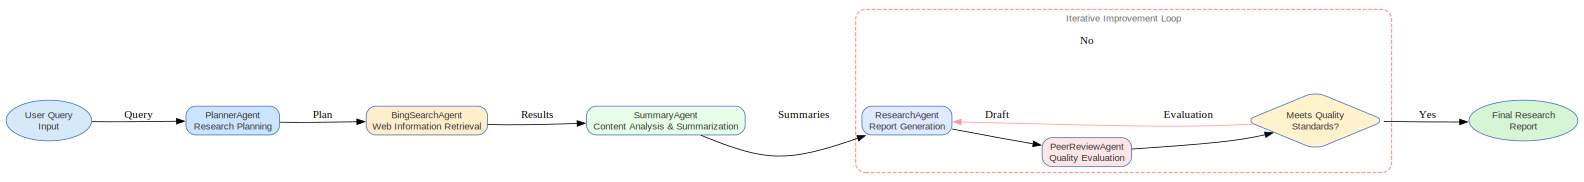

In [30]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [31]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [32]:
from agents import Runner

plan = await Runner().run(
    starting_agent=planner_agent,
    input=user_query
)

In [33]:
plan.final_output.research_tasks[0].search_queries

['What is classical machine learning?',
 'What is deep learning?',
 'What is generative AI?',
 'Core concepts of classical machine learning, deep learning, and generative AI']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [34]:
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

search_results = []

for subtopic in tqdm(plan.final_output.research_tasks, desc="Subtopics"):
    subtopic_results = {"subtopic": subtopic.subtopic, "queries": []}

    for query in tqdm(subtopic.search_queries, desc=f"Queries ({subtopic.subtopic})", leave=False):
        formatted_query = f"""
        Research the following query: {query}
        This is related to subtopic: {subtopic.subtopic}
        Please provide the information and cite your sources using the available tools.
        """
        try:
            thread = project_client.agents.threads.create()
            message = project_client.agents.messages.create(
                thread_id=thread.id,
                role="user",
                content=formatted_query,
            )

            # Process the run
            run = project_client.agents.runs.create_and_process(
                thread_id=thread.id,
                agent_id=bing_search_agent.id
            )

            agent_response_text, extracted_urls = extract_agent_response_and_urls(project_client, thread.id, query)

            # Add to our results collection
            subtopic_results["queries"].append({
                "query": query,
                "agent_response": agent_response_text,
                "results": extracted_urls
            })

            # Delete the thread after processing
            project_client.agents.threads.delete(thread_id=thread.id)

        except Exception as e:
            print(f"An error occurred processing query '{query}': {e}")
            # Optionally add error information to results
            subtopic_results["queries"].append({
                "query": query,
                "results": [],
                "error": str(e)
            })

    search_results.append(subtopic_results)

Subtopics: 100%|██████████| 5/5 [03:06<00:00, 37.34s/it]


In [35]:
print(f"Planned total search queries: {sum(1 for task in plan.final_output.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 20

Actually total search queries: 20



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [36]:
from common.utils_summary import collect_responses_and_citations

mapped_chunks = []

for subtopic_result in tqdm(search_results, desc="Summarizing subtopics"):
    all_agent_responses_for_subtopic, unique_citations_for_subtopic = collect_responses_and_citations(subtopic_result)

    # --- Summarize the combined agent responses ONCE per subtopic ---
    content_to_summarize = "\n\n---\n\n".join(all_agent_responses_for_subtopic)

    subtopic_summary = "No content found to summarize for this subtopic." # Default value
    if content_to_summarize:
        summary_prompt = f"Summarize the following information related to the subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content_to_summarize}"
        try:
            summary_response = await Runner().run(
                starting_agent=summary_agent,
                input=summary_prompt
            )
            subtopic_summary = summary_response.final_output # Adjust based on actual response structure
        except Exception as e:
            print(f"Error summarizing subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}': {e}")
            subtopic_summary = f"Error during summarization for subtopic '{subtopic_result.get('subtopic', 'Unknown Subtopic')}'. Details: {e}"
            # Depending on requirements, you might want to raise the exception, log it, or handle it differently

    # --- Convert set of tuples back to list of dictionaries (or Citation objects) ---
    citations_list = [
        {"title": title, "url": url}
        for title, url in unique_citations_for_subtopic
    ]

    # --- Append the consolidated result ---
    mapped_chunks.append({
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"), # Use .get for safety
        "summary": subtopic_summary,
        "citations": citations_list
    })

Summarizing subtopics: 100%|██████████| 5/5 [00:58<00:00, 11.71s/it]


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [37]:
plan.final_output

ResearchPlan(query='What are the differences between classical machine learning, deep learning and generative AI?', objective='To comprehensively analyze and articulate the key differences, overlaps, and unique characteristics of classical machine learning, deep learning, and generative AI, including their definitions, methodologies, applications, strengths, and limitations.', success_criteria=['Clear definitions and explanations of classical machine learning, deep learning, and generative AI are provided.', 'Key differences and similarities between the three approaches are identified and explained.', 'Examples of real-world applications for each approach are included.', 'Strengths and limitations of each approach are discussed.', 'A comparative summary or table is created to visually distinguish the three approaches.'], related_topics=['Supervised vs. unsupervised learning', 'Neural networks and their architectures', 'AI ethics and responsible AI development'], research_tasks=[Researc

In [38]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan.final_output, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

final_answer = await Runner().run(
    starting_agent=research_agent,
    input=(
        "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
        "using the following content. **Minimize bullet points** and ensure the final text resembles "
        "a cohesive, academic-style paper:\n\n"
        f"{research_input_prompt}\n\n"
        "As a final reminder, don't forget to include the citation list at the end of the report."
    ),
    max_turns=21 # 5 turns are needed for a full collaboration between ResearchAgent and PeerReviewAgent
)

### Extracting the Final Research Report

After the ResearchAgent and PeerReviewAgent complete their collaborative process, we extract the final research report from the agent outputs. The report includes:

1. A clearly defined research objective
2. Multiple sections covering all identified subtopics
3. In-depth analysis with facts, statistics, and insights
4. Proper citations using IEEE format
5. A comprehensive references section

In [39]:
from agents import HandoffCallItem
import json

def extract_research_report(final_answer):
    # If final output is from ResearchAgent, get the report directly
    if hasattr(final_answer.final_output, "research_report"):
        return final_answer.final_output.research_report
    
    # If final output is from PeerReviewAgent, find the latest research report from ResearchAgent
    for item in reversed(final_answer.new_items):  # Start from end to get the latest
        if isinstance(item, HandoffCallItem) and item.agent.name == "ResearchAgent":
            try:
                args = json.loads(item.raw_item.arguments)
                if "research_report" in args:
                    return args["research_report"]
            except (json.JSONDecodeError, AttributeError):
                continue
    
    # If we couldn't find a report
    raise ValueError("No research report found in the conversation history")

research_report = extract_research_report(final_answer)

### Final Report Presentation

The completed research report is displayed below in Markdown format. The report represents a comprehensive analysis of the original query, incorporating insights from multiple web sources and structured in an academic format with proper citations.

In [40]:
from IPython.display import display, Markdown
display(Markdown(research_report))

# A Comprehensive Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Definitions, Methodologies, Applications, Strengths, and Comparative Perspectives

## Introduction

The rapid evolution of artificial intelligence (AI) over recent decades has produced a rich tapestry of methodologies, each tailored to specific data types, problem domains, and operational constraints. Among the most prominent paradigms are classical machine learning, deep learning, and generative AI. These approaches, while sharing foundational principles rooted in data-driven learning, diverge significantly in their technical underpinnings, application domains, and transformative potential. This report provides an in-depth, integrated analysis of these three paradigms, exploring their core concepts, methodologies, real-world applications, strengths, and limitations. By synthesizing insights from academic literature, industry case studies, and comparative analyses, the report aims to clarify the nuanced distinctions and overlaps among these approaches, offering a comprehensive reference for practitioners, researchers, and decision-makers.

## 1. Definitions and Core Concepts

### 1.1 Classical Machine Learning

Classical machine learning (ML) refers to a suite of foundational algorithms and statistical models designed to uncover patterns and relationships within structured datasets. These methods are grounded in mathematical rigor and are typically divided into supervised and unsupervised learning. Supervised learning involves training models on labeled input-output pairs, with algorithms such as linear regression, logistic regression, decision trees, and support vector machines (SVMs) being prominent examples. Unsupervised learning, by contrast, seeks to identify structure in unlabeled data through clustering (e.g., k-means) and dimensionality reduction (e.g., principal component analysis, PCA) techniques. A defining characteristic of classical ML is its reliance on manual feature engineering, wherein domain experts select and transform variables to optimize model performance. This approach emphasizes interpretability, efficiency, and robust evaluation using metrics like accuracy, precision, recall, and cross-validation. Classical ML is particularly well-suited for structured data and scenarios where transparency and lower data requirements are critical [1][2][3][4][5].

### 1.2 Deep Learning

Deep learning represents a paradigm shift within AI, leveraging multi-layered artificial neural networks to automatically learn hierarchical representations from raw, often unstructured data. The term "deep" refers to the presence of multiple processing layers, each extracting increasingly abstract features from the input. Deep learning excels in domains such as image and speech recognition, natural language processing, and complex pattern recognition. Key architectures include convolutional neural networks (CNNs) for spatial data, recurrent neural networks (RNNs) for sequential data, and transformers for tasks requiring attention mechanisms. The core mechanism enabling deep learning is backpropagation, which iteratively adjusts network weights based on error gradients. Unlike classical ML, deep learning minimizes the need for manual feature engineering, instead discovering salient features autonomously. This capability has led to breakthroughs in fields previously inaccessible to traditional algorithms [1][2][3][4][5].

### 1.3 Generative AI

Generative AI is a specialized class of models designed to create novel content—such as text, images, music, and code—by learning the underlying distributions of training data. Unlike traditional predictive models, which focus on classification or regression, generative AI emphasizes the synthesis of new, original data. The core technologies driving generative AI include generative adversarial networks (GANs), variational autoencoders (VAEs), diffusion models, and large language models (LLMs) such as GPT. These models employ advanced training techniques, including adversarial learning and latent variable modeling, to produce outputs that are increasingly indistinguishable from human-generated content. Generative AI also introduces the concept of prompt engineering, wherein carefully crafted inputs guide models to produce desired outputs, a technique especially relevant for LLMs. The rise of generative AI is transforming creative and productive domains, enabling new forms of automation and augmentation [1][4].

### 1.4 Interplay and Evolution

The evolution from classical ML to deep learning and generative AI reflects a trajectory of increasing model complexity, data requirements, and creative potential. While classical ML remains indispensable for structured, interpretable tasks, deep learning has unlocked new frontiers in perception and understanding of complex data. Generative AI, in turn, is revolutionizing creative industries by automating and augmenting content creation. The interplay among these paradigms continues to shape the trajectory of AI research and deployment, with hybrid systems increasingly leveraging the strengths of each approach.

## 2. Methodologies and Algorithms

### 2.1 Classical Machine Learning Algorithms

The methodological foundation of classical machine learning lies in a diverse array of algorithms, each tailored to specific data types and problem complexities. Linear regression and logistic regression are among the most fundamental, providing transparent models for continuous and binary outcomes, respectively. Decision trees and random forests offer interpretable, tree-based structures for both classification and regression, with random forests enhancing robustness through ensemble learning. Support vector machines (SVMs) excel in high-dimensional spaces, optimizing the separation between classes. K-nearest neighbors (KNN) adopts a non-parametric approach, relying on the proximity of data points, while naive Bayes leverages probabilistic reasoning for tasks such as text classification. Unsupervised algorithms like k-means clustering and PCA facilitate data exploration and dimensionality reduction, respectively. Gradient boosting machines, including XGBoost and AdaBoost, sequentially improve predictions by correcting previous errors, achieving high accuracy in structured data tasks. These algorithms are typically implemented using open-source libraries and are favored for their interpretability, efficiency, and effectiveness with smaller datasets [6][7][8][9].

### 2.2 Deep Learning Architectures and Techniques

Deep learning methodologies are characterized by their use of artificial neural networks with multiple layers, enabling the automatic extraction of hierarchical features from raw data. Feedforward neural networks (FNNs) serve as the basic building blocks, while convolutional neural networks (CNNs) are specialized for grid-like data such as images, extracting spatial features through convolutional layers. Recurrent neural networks (RNNs), and their advanced variants like long short-term memory (LSTM) and gated recurrent units (GRU), are tailored for sequential data, maintaining memory of previous inputs for tasks such as language modeling and time series analysis. Transformers, leveraging self-attention mechanisms, have revolutionized natural language processing by enabling parallel processing of sequences and capturing long-range dependencies, as exemplified by models like BERT and GPT.

Training deep neural networks relies on the backpropagation algorithm, which computes gradients of loss functions with respect to model parameters and updates them using optimization techniques such as stochastic gradient descent (SGD). Regularization methods—including dropout, batch normalization, and weight decay—are essential for preventing overfitting and improving generalization. Transfer learning, wherein pre-trained models are fine-tuned on new tasks, and hyperparameter optimization strategies further enhance deep learning performance and adaptability. The scalability and flexibility of deep learning architectures have made them indispensable for tasks involving unstructured, high-dimensional data [6][7][8][9].

### 2.3 Generative AI Methodologies

Generative AI introduces specialized algorithms designed to create new, realistic data. Generative adversarial networks (GANs) pit a generator against a discriminator in a competitive training process, producing highly realistic outputs. Variational autoencoders (VAEs) introduce probabilistic latent variables, enabling the generation of new, similar data samples. Diffusion models, such as denoising diffusion probabilistic models (DDPMs), iteratively refine noise into structured outputs, achieving state-of-the-art results in image generation. Transformer-based generative models, notably GPT for text and DALL-E for images, employ attention mechanisms to generate coherent and contextually relevant outputs. Autoregressive models (e.g., PixelRNN, WaveNet) generate data sequentially, conditioning each new element on previous outputs, while flow-based models (e.g., RealNVP, Glow) learn invertible mappings for efficient sampling and exact likelihood estimation.

The training of generative models often involves unsupervised or self-supervised learning paradigms, with loss functions tailored to the specific architecture: adversarial loss for GANs, reconstruction loss for autoencoders, and likelihood-based losses for VAEs and flow models. Advanced techniques such as attention mechanisms, latent variable modeling, and iterative refinement are central to recent breakthroughs, enabling the synthesis of high-quality, diverse, and realistic data. These methodological advances have positioned generative AI at the forefront of artificial creativity and automation [6][7][8][9].

### 2.4 Methodological Distinctions and Overlaps

While classical ML, deep learning, and generative AI each employ distinct methodologies, there is considerable overlap in foundational principles. All three rely on data-driven learning, optimization of objective functions, and iterative refinement of model parameters. The primary distinctions lie in data requirements, feature engineering, interpretability, computational demands, and the range of applicable tasks. Classical ML emphasizes manual feature engineering and interpretability, deep learning automates feature extraction and excels with unstructured data, and generative AI extends deep learning architectures to content creation and synthesis. The choice of methodology is dictated by the nature of the data, the complexity of the task, and resource availability.

## 3. Applications and Use Cases

### 3.1 Classical Machine Learning Applications

Classical machine learning remains foundational for structured data tasks across a range of industries. In healthcare, classical ML algorithms are used for disease diagnosis and prognosis, such as predicting diabetes or cancer risk, and for clustering patient data to tailor personalized treatment plans. The finance sector leverages logistic regression and decision trees for credit scoring, fraud detection, stock market prediction, and portfolio optimization. Marketing and retail benefit from clustering methods for customer segmentation, churn prediction, and recommendation systems. In manufacturing, regression and classification models enable predictive maintenance and defect detection, enhancing operational efficiency. Classical ML also underpins natural language processing (NLP) tasks such as spam detection and sentiment analysis, as well as document clustering and topic modeling. In image processing, these algorithms support object recognition and pattern detection, particularly in medical imaging. These approaches are favored for their interpretability, computational efficiency, and effectiveness with smaller datasets, and are often the starting point before transitioning to more complex deep learning models, especially in regulated or resource-constrained environments [10][11][12][13][14][15][16][17][18][19][20][21].

### 3.2 Deep Learning Applications

Deep learning has transformed industries by enabling advanced analysis of unstructured data—images, audio, and text—where classical ML often falls short. In healthcare, deep learning models analyze X-rays, MRIs, and CT scans to detect diseases such as cancer and neurological disorders with higher accuracy than classical ML. They also accelerate drug discovery by predicting molecular interactions and enable personalized medicine through comprehensive patient data analysis. In finance, deep learning powers real-time fraud detection, algorithmic trading, and nuanced risk assessment by modeling complex, high-dimensional data. Retailers utilize deep learning for personalized recommendation systems, predictive inventory management, and customer sentiment analysis from social media and reviews. Manufacturing applications include predictive maintenance using sensor data and automated visual inspection systems for quality control. Agriculture benefits from deep learning in crop monitoring and yield prediction, optimizing resource allocation and improving outcomes. The transportation and automotive sectors leverage deep learning for autonomous vehicles—processing sensor and camera data for navigation and obstacle avoidance—and for traffic prediction and route optimization. Security applications include facial recognition for surveillance and authentication, as well as anomaly detection in cybersecurity. Deep learning’s ability to model complex, nonlinear relationships and extract features from raw data has made it indispensable for tasks requiring high accuracy and automation, albeit often at the cost of interpretability and higher computational demands [10][11][12][13][14][15][16][17][18][19][20][21].

### 3.3 Generative AI Applications

Generative AI is rapidly expanding into creative, conversational, and automation-driven applications. In search and information retrieval, companies such as Google integrate generative AI to produce AI-generated overviews and summaries, increasing user engagement and the relevance of search results. Conversational agents and virtual assistants, powered by generative AI, handle complex queries, maintain contextual conversations, and automate customer service and scheduling. Content creation is a major domain, with AI tools generating text, images, music, and videos for applications ranging from automated news writing and marketing copy to graphic design and video game development. In healthcare, generative AI creates synthetic medical data and images for training, augments datasets, and assists in diagnostics and personalized treatment planning. Education benefits from AI-driven tutoring systems and content generators that personalize learning materials and simulate exam questions. Generative AI also transforms software development, with tools like GitHub Copilot suggesting code snippets, automating repetitive tasks, and generating entire functions from natural language descriptions. In product design and prototyping, generative design tools produce optimized prototypes by exploring multiple design variations based on specified constraints. Legal and financial services utilize generative AI for drafting documents, summarizing contracts, and generating reports, streamlining operations and reducing manual workload [10][11][12][13][14][15][16][17][18][19][20][21].

### 3.4 Comparative Case Studies and Industry Nuances

Comparative analyses highlight that classical ML is optimal for structured, well-defined problems, deep learning excels with unstructured and complex data, and generative AI is pioneering new frontiers in content generation and user interaction. For example, in healthcare diagnostics, classical ML predicts patient outcomes from structured records, deep learning analyzes medical images for disease detection, and generative AI generates synthetic images for training and drafts clinical reports. In marketing, classical ML segments customers, deep learning personalizes recommendations, and generative AI creates tailored ad content, enhancing engagement and conversion rates. In search, classical ML ranks results, deep learning enables semantic search and intent understanding, and generative AI delivers direct answers and content generation, as seen in advanced platforms like Azure AI Search. The synergy between these approaches is increasingly evident, with hybrid systems leveraging the interpretability of classical ML, the representational power of deep learning, and the creativity of generative AI.

### 3.5 Impact Assessment Matrix Across Industries

The following table summarizes the impact of each AI paradigm across key industries:

| Industry        | Classical ML         | Deep Learning           | Generative AI                  |
|-----------------|---------------------|-------------------------|-------------------------------|
| Healthcare      | Risk prediction, diagnosis | Medical imaging, drug discovery | Synthetic data, report drafting |
| Finance         | Credit scoring, fraud detection | Algorithmic trading, risk modeling | Automated reporting, document generation |
| Retail/Marketing| Customer segmentation, churn | Personalization, sentiment analysis | Ad content, product descriptions |
| Manufacturing   | Predictive maintenance, defect detection | Visual inspection, process optimization | Design prototyping, synthetic data |
| Education       | Student performance prediction | Adaptive learning, grading | Content generation, tutoring systems |
| Transportation  | Route optimization, demand prediction | Autonomous vehicles, traffic analysis | Simulation, scenario generation |

## 4. Strengths and Limitations

### 4.1 Classical Machine Learning

Classical ML algorithms are celebrated for their interpretability, efficiency, and strong performance on structured data with smaller datasets. Decision trees and linear regression, for instance, provide transparent, easily understood decision-making processes, enabling practitioners to trace and justify predictions. These models are computationally lightweight, requiring less memory and processing power compared to deep learning, making them ideal for deployment on smaller datasets or less powerful hardware. Training times are typically short, and classical ML often achieves strong results on structured/tabular data where relationships are relatively straightforward. Another significant advantage is their lower data requirement; classical ML can perform well even with limited data, whereas deep learning models generally necessitate vast datasets to avoid overfitting and achieve high accuracy. However, these strengths are counterbalanced by notable limitations. Classical ML models struggle with unstructured data types such as images, audio, or free-form text, where the relationships are complex and high-dimensional. Their predictive power is often capped by their limited expressiveness, meaning they may fail to capture intricate patterns present in the data. Furthermore, classical ML typically requires extensive manual feature engineering—crafting input variables based on domain expertise—to extract meaningful signals from the data, a process that is both time-consuming and reliant on human intuition. Scalability can also be an issue; algorithms like k-nearest neighbors become computationally expensive as dataset size grows. As a result, in many modern applications, classical ML models reach a performance plateau, after which only more sophisticated techniques, such as deep learning, can provide further improvements [22][23][24][25][26][27][28][29][30][31][32].

### 4.2 Deep Learning

Deep learning, characterized by multi-layered neural networks such as CNNs and large language models (LLMs), has revolutionized AI by achieving state-of-the-art results in domains like image recognition, speech processing, and natural language understanding. These models excel at learning complex, hierarchical representations directly from raw data, eliminating the need for manual feature engineering. Their scalability allows them to leverage massive datasets, often improving performance as more data becomes available. End-to-end learning enables deep learning systems to map inputs to outputs in a flexible, task-agnostic manner, and with proper regularization, these models can generalize well to unseen data. Despite these strengths, deep learning comes with substantial limitations. Training deep neural networks requires enormous labeled datasets and significant computational resources, such as GPUs or TPUs, which can be prohibitive for smaller organizations or niche applications. The "black box" nature of deep learning architectures poses challenges for interpretability and transparency, making it difficult to understand or trust their decision-making processes. Deep learning models are also susceptible to adversarial attacks—small, often imperceptible perturbations in input data can result in dramatically incorrect outputs. Overfitting is a persistent risk, especially when data is insufficient or regularization is inadequate. Furthermore, deep learning systems can inadvertently learn and amplify biases present in training data, raising concerns about fairness and ethical deployment. They also struggle with causal reasoning, excelling at pattern recognition but failing to infer underlying mechanisms or cause-effect relationships [22][23][24][25][26][27][28][29][30][31][32].

### 4.3 Generative AI

Generative AI, particularly large language models and image generators, has demonstrated remarkable capabilities in content creation and automation. These models can produce coherent text, realistic images, and other media by learning patterns from vast corpora of training data. However, their limitations are significant. Generative AI often lacks deep understanding or reasoning abilities, excelling only at well-defined, narrow tasks and struggling with complex, multi-dimensional societal issues. The quality and representativeness of training data are critical; biased or incomplete data leads to skewed, inappropriate, or even harmful outputs. A major concern is "hallucination," where models generate plausible-sounding but factually incorrect or fabricated information, undermining reliability in high-stakes applications. Generative models also have limited contextual awareness and memory, which can result in inconsistent or irrelevant outputs in extended interactions. Ethical and security risks are pronounced: generative AI can be misused for misinformation, deepfakes, and malicious content, and raises issues around privacy, copyright, and the amplification of harmful stereotypes. When faced with ambiguity or incomplete information, these models often default to generic or vague responses, highlighting their limitations in nuanced reasoning and decision-making [22][23][24][25][26][27][28][29][30][31][32].

### 4.4 Symbolic AI and Hybrid Approaches

Symbolic AI, or rule-based systems, are highly interpretable and transparent, making them effective in domains with clear, well-defined rules. Their reasoning processes can be easily traced and audited, which is valuable in regulated or safety-critical environments. However, symbolic AI faces scalability challenges; encoding exhaustive rules for complex, real-world problems is labor-intensive and often infeasible. These systems are inflexible, struggling with ambiguity, exceptions, and evolving knowledge, as rules must be manually updated. Knowledge acquisition requires significant expert input, further limiting their adaptability and scalability. Hybrid approaches seek to combine the reasoning capabilities of symbolic AI with the pattern recognition strengths of machine learning and deep learning, aiming to improve robustness and explainability in complex applications. However, integrating these paradigms remains an active area of research due to the inherent complexity of blending symbolic reasoning with data-driven learning [22][23][24][25][26][27][28][29][30][31][32].

### 4.5 Cross-Cutting AI Implementation Challenges

Across all AI paradigms, common implementation challenges include ensuring data privacy and security, navigating regulatory and ethical considerations, integrating AI with existing systems, and addressing the need for skilled personnel. Addressing these challenges often requires both technical solutions—such as explainable AI methods and improved data quality—and organizational strategies, including robust governance frameworks and ongoing staff training. The choice of AI approach depends heavily on the specific task, data characteristics, and operational constraints. Understanding these strengths and limitations is essential for effective, responsible, and context-appropriate AI deployment, and ongoing research continues to address many of these challenges, particularly around interpretability, fairness, and scalability.

## 5. Comparative Analysis and Summary

### 5.1 Comparative Table

A comparative analysis of classical machine learning, deep learning, and generative AI reveals a spectrum of approaches within artificial intelligence, each tailored to specific types of data, computational environments, and problem domains. The following table summarizes the key differences and overlaps:

| Aspect                | Classical ML      | Deep Learning           | Generative AI                        |
|-----------------------|------------------|------------------------|--------------------------------------|
| Data Requirements     | Small/Medium     | Large                  | Massive, often self-supervised       |
| Feature Engineering   | Manual           | Automatic              | Automatic, complex representations   |
| Model Complexity      | Simple           | Complex (deep networks)| Very complex (LLMs, GANs, diffusion) |
| Interpretability      | High             | Low                    | Lowest                              |
| Computational Power   | Low/Moderate     | High                   | Very high                           |
| Output                | Predictions      | Predictions, patterns  | Novel content (text, images, etc.)   |
| Use Cases             | Tabular data     | Vision, audio, NLP     | Content generation, creative tools   |

### 5.2 Hierarchical Breakdown of AI Paradigms

A hierarchical view of AI paradigms further clarifies their relationships:

- **Artificial Intelligence**
  - **Symbolic AI (Rule-Based Systems)**
  - **Machine Learning**
    - **Classical Machine Learning**
    - **Deep Learning**
      - **Generative AI**

### 5.3 Timeline of Major Developments

| Year/Period | Major Development                                 |
|-------------|---------------------------------------------------|
| 1950s-1980s | Symbolic AI, expert systems                       |
| 1990s       | Classical ML algorithms (SVM, decision trees, etc.)|
| 2006        | Deep learning resurgence (Hinton et al.)          |
| 2012        | CNN breakthrough (ImageNet competition)           |
| 2014        | GANs introduced                                   |
| 2017        | Transformers (Vaswani et al.)                     |
| 2018-2020s  | LLMs (GPT, BERT), diffusion models, generative AI |

### 5.4 Synthesis and Future Directions

The choice between classical ML, deep learning, and generative AI depends on the nature of the data, the complexity of the task, the need for interpretability, and available computational resources. Classical ML remains relevant for structured, interpretable tasks with limited data, while deep learning and generative AI dominate domains involving unstructured data and creative content generation, albeit with greater resource demands and challenges in model transparency. Symbolic and hybrid approaches continue to play important roles in domains where explainability and logical reasoning are critical, pointing toward a future where integrated AI systems leverage the strengths of multiple paradigms. As generative AI matures, its role in automating complex tasks, enhancing creativity, and improving decision-making will expand, while classical and deep learning methods will remain essential for foundational tasks and as components within larger AI systems. The ongoing convergence of these paradigms, coupled with advances in explainability, fairness, and scalability, will shape the next generation of AI solutions.

## References

[1] Why Is Deep Learning Actually Called “Deep”? - aievo.co.uk, https://aievo.co.uk/why-is-deep-learning-actually-called-deep/

[2] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/classic-and-adaptive-machines/

[3] Classic Machine Learning Methods - SpringerLink, https://link.springer.com/protocol/10.1007/978-1-0716-3195-9_2

[4] AI Mode in Google Search: Updates from Google I/O 2025 - The Keyword, https://blog.google/products/search/google-search-ai-mode-update/

[5] Classical Machine Learning Models | ageron/handson-ml3 | DeepWiki, https://deepwiki.com/ageron/handson-ml3/4-classical-machine-learning-models

[6] Deep Learning vs. Machine Learning: Everything You Need to Know, https://pg-p.ctme.caltech.edu/blog/ai-ml/deep-learning-vs-machine-learning

[7] Deep Learning (DL) vs Machine Learning (ML): A Comparative Guide, https://www.datacamp.com/tutorial/machine-deep-learning

[8] Machine Learning and Deep Learning: A Comparative Review, https://link.springer.com/chapter/10.1007/978-981-33-6307-6_15

[9] Difference Between Machine Learning and Deep Learning, https://www.geeksforgeeks.org/difference-between-machine-learning-and-deep-learning/

[10] Introducing AI Max for Search campaigns - The Keyword, https://blog.google/products/ads-commerce/google-ai-max-for-search-campaigns/

[11] Up to 40% better relevance for complex queries with new agentic ..., https://techcommunity.microsoft.com/blog/azure-ai-services-blog/up-to-40-better-relevance-for-complex-queries-with-new-agentic-retrieval-engine/4413832

[12] 20 Deep Learning Applications in 2024 Across Industries, https://www.pickl.ai/blog/deep-learning-applications/

[13] Classic machine learning methods - arXiv.org, https://arxiv.org/pdf/2310.11470

[14] Agentic Retrieval - Azure AI Search | Microsoft Learn, https://learn.microsoft.com/en-us/azure/search/search-agentic-retrieval-concept

[15] Top 20 Applications of Deep Learning in 2025 Across Industries, https://www.mygreatlearning.com/blog/deep-learning-applications/

[16] A Guided Tour Through Classical Machine Learning Algorithms, https://learn.mathnai.com/module/ml/guided-tour-classical-ml-algorithms/

[17] Top 50 Deep Learning Use Case & Case Studies in 2025 - AIMultiple, https://research.aimultiple.com/deep-learning-applications/

[18] AI Mode in Google Search: Updates from Google I/O 2025 - The Keyword, https://blog.google/products/search/google-search-ai-mode-update/

[19] Deep Learning Use Cases – A Roadmap to Digital Transformation, https://www.matellio.com/blog/deep-learning-business-use-cases/

[20] Machine Learning Theory and Applications: Hands-on Use Cases with ..., https://ieeexplore.ieee.org/book/10444091

[21] Classic machine learning methods - arXiv.org, https://arxiv.org/pdf/2310.11470

[22] Comprehensive Overview of the Opportunities and Challenges in AI, https://ieeexplore.ieee.org/document/10169722

[23] Understanding The Limitations Of Generative AI - Forbes, https://www.forbes.com/councils/forbestechcouncil/2024/05/09/understanding-the-limitations-of-generative-ai/

[24] Strengths and weaknesses of deep learning models for face recognition ..., https://ietresearch.onlinelibrary.wiley.com/doi/epdf/10.1049/iet-bmt.2017.0083

[25] Key Concepts and Considerations in Generative AI, https://learn.microsoft.com/en-us/azure/developer/ai/gen-ai-concepts-considerations-developers

[26] The Top 5 challenges implementing AI — and how to overcome them, https://www.glideapps.com/blog/challenges-implementing-ai

[27] What are the limitations of generative AI? - AiOps Redefined!!!, https://www.theaiops.com/what-are-the-limitations-of-generative-ai/

[28] Bridging the gaps: Overcoming challenges of implementing AI in ..., https://www.sciencedirect.com/science/article/pii/S2666634025000935

[29] Assessing the Strengths and Weaknesses of Large Language Models - Springer, https://link.springer.com/article/10.1007/s10849-023-09409-x

[30] 6 AI Implementation Challenges And How To Overcome Them, https://elearningindustry.com/ai-implementation-challenges-and-how-to-overcome-them

[31] 10 Major Challenges of Generative AI & How to Overcome Them, https://www.theiotacademy.co/blog/challenges-of-generative-ai/

[32] Deep Learning Models for Face Recognition: A Comparative Analysis, https://link.springer.com/chapter/10.1007/978-3-030-32583-1_6

[33] Generative AI vs Machine Learning vs Deep Learning Differences - Redblink, https://redblink.com/generative-ai-vs-machine-learning-vs-deep-learning/

[34] Generative Ai And Deep Learning: Delving Into The Difference, https://learnaiinfo.com/difference-between-generative-ai-and-deep-learning/

[35] Generative AI vs Traditional AI: Key Differences in ML and DL - K21Academy, https://k21academy.com/ai-ml/deep-learning-ml-generative-ai/

[36] AI, ML, DL, and Generative AI Face Off: A Comparative Analysis, https://synoptek.com/insights/it-blogs/data-insights/ai-ml-dl-and-generative-ai-face-off-a-comparative-analysis/

---

This report has sought to provide a comprehensive, integrated analysis of classical machine learning, deep learning, and generative AI, elucidating their definitions, methodologies, applications, strengths, limitations, and comparative distinctions. The ongoing evolution and convergence of these paradigms will continue to shape the future of AI research, deployment, and societal impact.

### Research Workflow Visualization

Below we can see the detailed steps in the research and review process, showing how the ResearchAgent and PeerReviewAgent collaborated to produce the final report. This visualization helps us understand how many iterations were required to meet quality standards.

In [41]:
from common.helper import pretty_print_agent_workflow
pretty_print_agent_workflow(final_answer)

🔍 AGENT WORKFLOW: 'Create an exceptionally comprehensive, **paragraph-focused** and detailed research report using the following content. **Minimize bullet points** and ensure the final text resembles a cohesive, academic-style paper:

{
  "objective": "To comprehensively analyze and articulate the key differences, overlaps, and unique characteristics of classical machine learning, deep learning, and generative AI, including their definitions, methodologies, applications, strengths, and limitations.",
  "aggregated_summaries": [
    {
      "subtopic": "Definitions and Core Concepts",
      "summary": "Acknowledging that the input combines information potentially from multiple search results, here is a unified summary focused on the subtopic 'Definitions and Core Concepts' for classical machine learning, deep learning, and generative AI.\n\n---\n\n## Key Insights\n- **Classical machine learning** encompasses foundational, statistically-driven algorithms for structured data, emphasizing